In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import hvplot.pandas as hvplot
plt.style.use('seaborn')
!pip install ta
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
import ta as ta
# Initial imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pathlib import Path
import pandas as pd

In [2]:
def download(ticker):
# Note: We could have period < 60d and an intraday return
# Just change period to < 60 days and add interval = 1h
    df = yf.download(ticker, 
                period = '60d', # A period of 2 years from today
                prepost = False, # Pre and Post markets included
                threads = True, # Multi-thread processing for faster output.
                interval = '15m')
    return df
df = download("TSLA")

#data cleaning
print(df.describe())
print(df.isna().sum())


[*********************100%***********************]  1 of 1 completed
              Open         High          Low        Close    Adj Close  \
count  1556.000000  1556.000000  1556.000000  1556.000000  1556.000000   
mean    728.260222   731.484609   724.819090   728.170133   728.170133   
std      81.759552    81.361266    82.181344    81.799173    81.799173   
min     546.390015   562.619995   539.489990   546.710022   546.710022   
25%     673.860001   676.684998   670.479996   673.498749   673.498749   
50%     702.017761   704.759949   699.444489   701.969910   701.969910   
75%     799.164810   801.655014   796.237503   798.910004   798.910004   
max     895.599976   900.400024   888.504272   895.619995   895.619995   

             Volume  
count  1.556000e+03  
mean   1.261319e+06  
std    1.039408e+06  
min    0.000000e+00  
25%    6.376038e+05  
50%    9.564965e+05  
75%    1.519928e+06  
max    1.390479e+07  
Open         0
High         0
Low          0
Close        0
Adj Cl

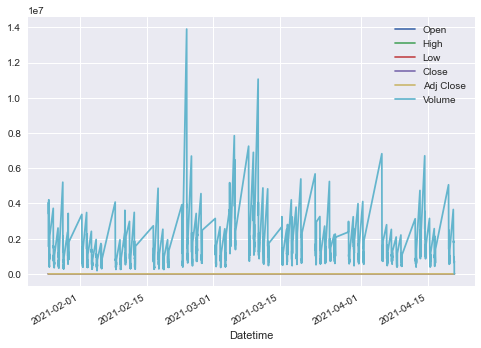

In [5]:
yahoo_orig=df.plot()

In [16]:
def get_indicators(data):
    #calculate all indicators
    open =data.loc[:,'Open']
    high=data.loc[:,'High']
    low=data.loc[:,'Low']
    close=data.loc[:,'Close']
    volume=data.loc[:,'Volume']
    data['returns']=data['Close'].pct_change()
    data['volatility']=data['returns'].rolling(window=32).std()*(252**0.5)
    data['rsi']=ta.momentum.rsi(close)
    data['macd_diff']=ta.trend.macd_diff(close)
    data =data.dropna()
    return data

<AxesSubplot:xlabel='Datetime'>

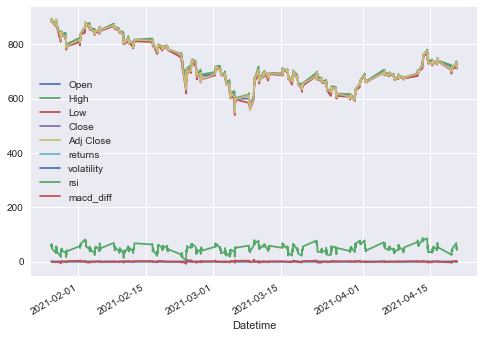

In [18]:
df_indicators=get_indicators(df).dropna()
df_indicators.plot()

df_indicators_only=df_indicators.drop(columns=['Volume','High','Open','Close','Low','Adj Close','volaltility','returns'])
df_indicators_only.plot()

df_indicators_important=df_indicators_only.drop(columns='rsi')
df_indicators_important.plot()

Feature:  rsi Score: 0.9091615
Feature:  macd_diff Score: -4.5183525


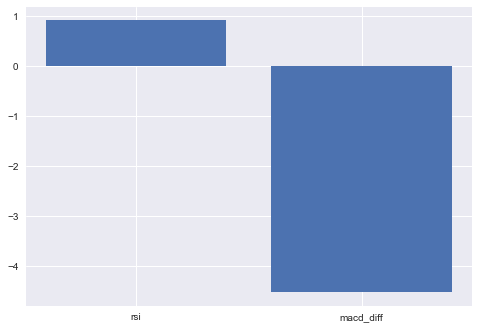

<AxesSubplot:>

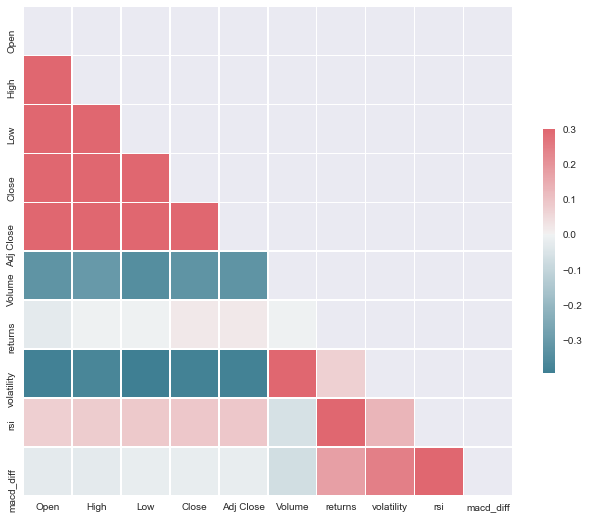

In [26]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
# define dataset

X, y = make_regression(n_samples=1547, n_features=6)
# define the model
model = LinearRegression()
# fit the model
X = df_indicators.drop(columns=['Open','High','Close','Adj Close','Low','returns','volatility','Volume'])
y = df_indicators['Close'].values
model.fit(X, y)
#Mapping column names for feature importance graph
map_colums ={}
col =df_indicators.drop(['Open','High','Close','Adj Close','Low','returns','volatility','Volume'],axis=1).columns
for i in range(len(col)):
 map_colums[i] = col[i]
map_colums
# get importancea
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: ',map_colums[i],'Score: %.7f' % v)
# plot feature importance
plt.bar([map_colums[x] for x in range(len(importance))], importance)
plt.show()

data=df.dropna()
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})